<a href="https://colab.research.google.com/github/kjkjindal/pytorch_basics/blob/main/pbmc_3k_classifier_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plot some key evaluation metrics for our classifier
1.   We already plotted training and validation loss so we will focus on other metrics now



In [1]:
#connect drive
from google.colab import drive
drive.mount('/content/drive')

#add custom lib path
import os, sys
sys.path.append('/content/drive/My Drive/libs')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import shap

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils as utils

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

import scanpy as sc

In [4]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(1838, 50)
    self.bn1 = nn.BatchNorm1d(50)
    self.fc2 = nn.Linear(50,10)
    self.bn2 = nn.BatchNorm1d(10)
    self.fc3 = nn.Linear(10,1)

  def forward(self, input):
    f1 = self.fc1(input)
    f1 = F.relu(self.bn1(f1))

    f2 = self.fc2(f1)
    f2 = F.relu(self.bn2(f2))

    f3 = F.sigmoid(self.fc3(f2))
    return f3

net = Net()

In [5]:
#load trained model
net.load_state_dict(torch.load('/content/drive/MyDrive/single_cell/data/pbmc_3k_model.pth'))

<ipython-input-5-96670d6d39dd>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('/content/drive/MyDrive/single_cell/data/pbmc_3k_model.pth'))


<All keys matched successfully>

In [28]:
#load and setup data
gex = pd.read_csv('/content/drive/MyDrive/single_cell/data/pbmc_3k_proc.csv', index_col=0)
meta = pd.read_csv('/content/drive/MyDrive/single_cell/data/pbmc_3k_proc_meta.csv', index_col=0)

assert((gex.index == meta.index).all())

labels = meta['immune'].apply(lambda x: 0. if x=='adaptive' else 1.).values
labels = torch.from_numpy(labels)
labels = labels.type(torch.float32)

data = torch.from_numpy(gex.values)

train_data, test_data, train_labels, test_labels, train_idx, test_idx = train_test_split(data, labels, gex.index.values, test_size = 0.2,
                                                                    random_state = 42, stratify = labels)

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.1,
                                                                    random_state = 42, stratify = train_labels)

len(train_labels), len(val_labels), len(test_labels)

train_dataset = TensorDataset(train_data, train_labels)
val_dataset = TensorDataset(val_data, val_labels)
test_dataset = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle=False)

In [7]:
#Confusion matrix
net.eval()

with torch.no_grad():
  preds = net(test_data.float())
  pred_discrete = [0 if x < 0.5 else 1 for x in preds]

In [13]:
cm = confusion_matrix(test_labels, pred_discrete)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Adaptive", "Innate"])

#0 is adaptive, 1 is innate

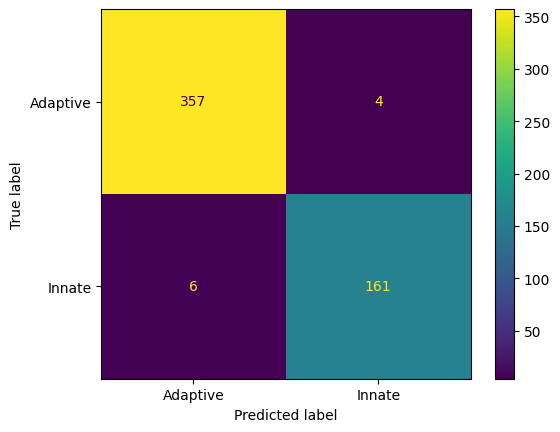

In [14]:
disp.plot()

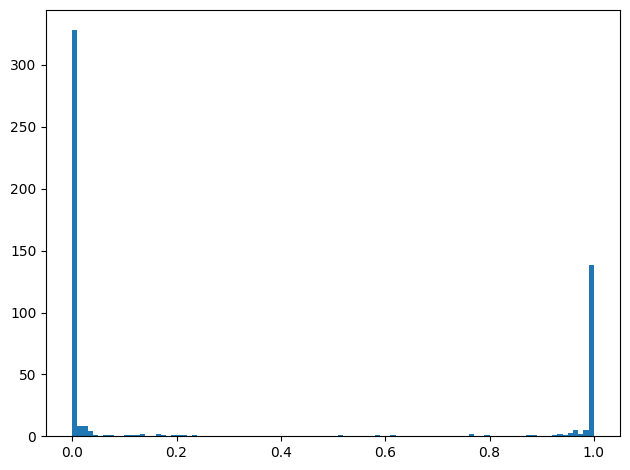

In [15]:
plt.hist(preds, bins=100)
plt.tight_layout()

Text(0.5, 1.0, 'ROC curve (AUC = 0.99731)')

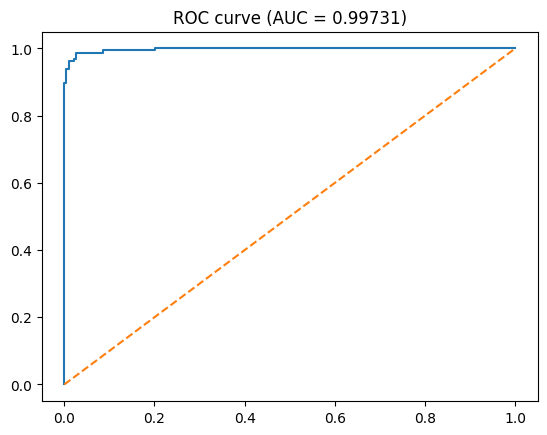

In [16]:
fpr, tpr, th = roc_curve(test_labels, preds)
auc = roc_auc_score(test_labels, preds)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.title(f'ROC curve (AUC = {auc:.5f})')

Text(0.5, 1.0, 'PR curve (AUPR = 0.99516)')

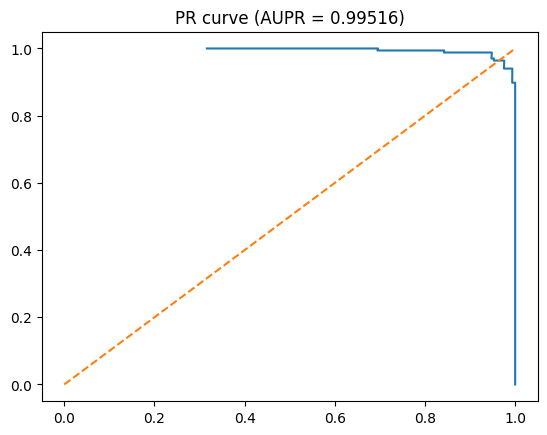

In [17]:
#precision recall characteristics
p,r, _ = precision_recall_curve(test_labels, preds)
aupr = average_precision_score(test_labels, preds)

plt.figure()
plt.plot(p, r)
plt.plot([0, 1], [0, 1], '--')
plt.title(f'PR curve (AUPR = {aupr:.5f})')

In [23]:
#plot umap of test data points
adata = sc.datasets.pbmc3k_processed()

  0%|          | 0.00/23.5M [00:00<?, ?B/s]

In [56]:
adata.obs['immune'] = 'innate'
adata.obs.loc[adata.obs.louvain.isin(['CD4 T cells', 'CD8 T cells', 'B cells']),'immune'] = 'adaptive'

adata_test = adata[test_idx].copy()
assert((adata_test.obs_names.values == test_idx).all())

In [57]:
#add to meta is label was predicted correctly or not
adata_test.obs['pred_state'] = (test_labels == np.array(pred_discrete)).numpy()
adata_test.obs['pred_state'] = adata_test.obs['pred_state'].apply(lambda x:"Correct" if x else "Incorrect")

In [64]:
adata_test.uns['pred_state_colors'] = ['#5ec962', '#3b528b']

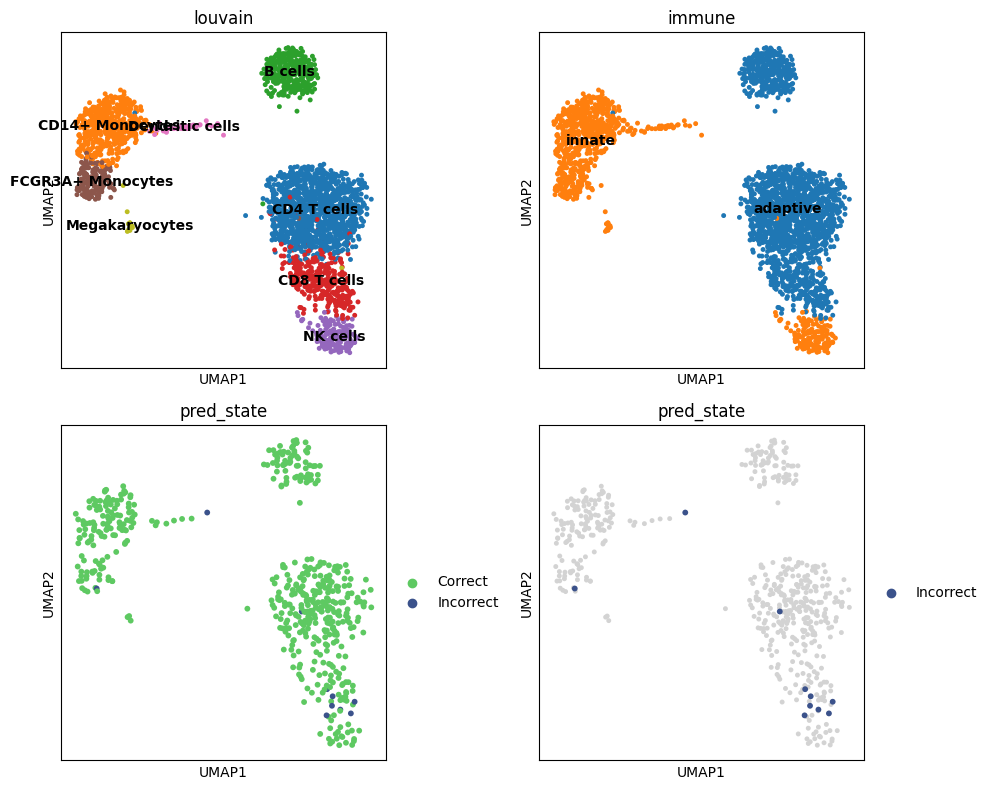

In [83]:
fig = plt.figure(figsize=(10,8))
gs = GridSpec(2,2)


ax = plt.subplot(gs[0])
sc.pl.umap(adata, color = 'louvain', ax=ax, show=False, s=50, legend_loc= 'on data')

ax = plt.subplot(gs[1])
sc.pl.umap(adata, color = 'immune', ax=ax, show=False, s=50, legend_loc= 'on data')

ax=plt.subplot(gs[2])
sc.pl.umap(adata_test, color = 'pred_state', ax=ax, s=70, show=False)

ax=plt.subplot(gs[3])
sc.pl.umap(adata_test, s=50, ax=ax, show=False)
sc.pl.umap(adata_test[adata_test.obs.pred_state=='Incorrect'], color = 'pred_state', ax=ax, s=70, show=False)

plt.tight_layout()

In [84]:
#most of the misclassifications are at the T-cell, Nk cell boundary, which makes sense given their shared origin